# Construct a time series predictor and an online learning algorithm   

I have used the data from https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datetime import datetime, time, timedelta

import re

In [27]:
from src.Transformers_TS import *
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score

from pandas.plotting import autocorrelation_plot
from pandas import rolling_mean, Series

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base

In [3]:
df = pd.read_csv(r'train_1.csv', sep=',', engine='python', skiprows=0, nrows=30).drop_duplicates().set_index('Page')

dates = df.columns.values
date0 = datetime(2015, 7, 1, 0, 0)
dates = np.array([ datetime.strptime(el, "%Y-%m-%d") for el in dates ] )


my_series = {}
for index, row in df.iterrows():
    my_series[index] = row.values

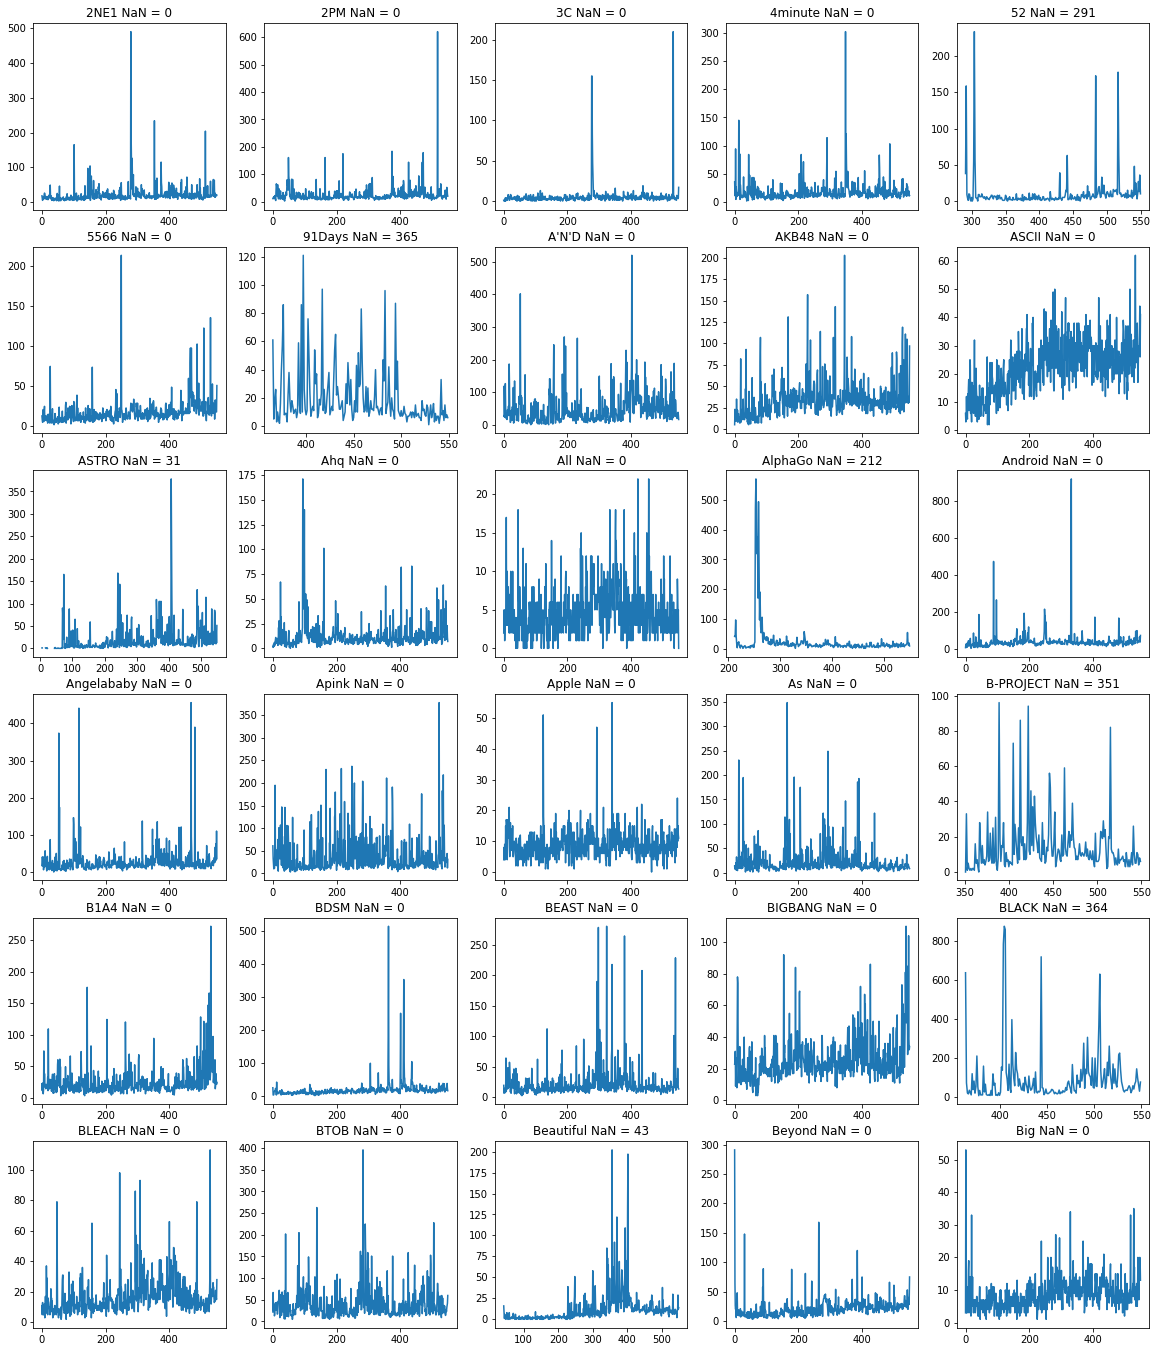

In [4]:
rows_ = df.shape[0]/5 + 1*(df.shape[0]%5!=0)

plt.figure( figsize=(20,rows_*4) )

for idx, key in enumerate(my_series):
    
    plt.subplot(rows_,5, idx+1)    
    plt.plot( my_series[key])
    plt.title(  re.split('_', key[:15])[0] + ' NaN = ' + str(np.count_nonzero(np.isnan(my_series[key]))) )
    
plt.show()

# Pick ASCII   

In [5]:
df_ = pd.DataFrame(data = my_series['ASCII_zh.wikipedia.org_all-access_spider'], columns = ['counts'], index = dates )

X_train, X_test, Y_train, Y_test = df_[:365], df_[365:], df_['counts'].values[:365], df_['counts'].values[365:]

X_test = X_test.index

### Apply Fourier transformation of the datapoints  
Since the frequencies that can be taken into account are in multiples of 1/(1.5 years) we will not be able to get the yearly correlations from the FT. SO we will apply FFT only to the first year of the data.  

If we want to create a function with frequency (1/yr) we can use as a basis functions with frequency (n/yr).  
If the periodic function does not have a sinusoidal form, then we will have to use a large number of sin functions to reconstrut it.  
To avoid overfitting we could just take the frequencies with the largest (by absolute value) amplitude.

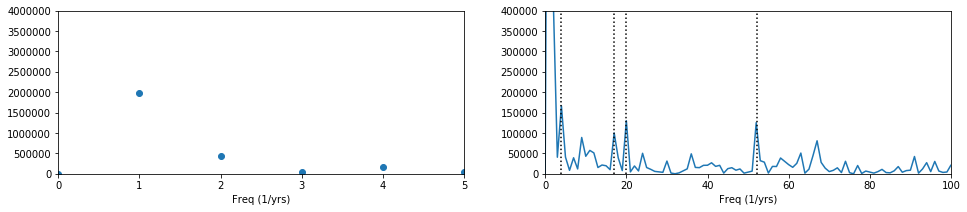

In [7]:
fft_counts = np.fft.fft(df_['counts'][:365].values - df_['counts'][:365].mean())
yrs = df_[:365].shape[0]/365.

plt.figure(figsize = (16,3))

plt.subplot(1,2,1)
plt.scatter( 1.0*np.arange(len(fft_counts))/yrs , np.abs(fft_counts)**2)
plt.axis([0, 5, 0, 4e6])
plt.xlabel('Freq (1/yrs)')

plt.subplot(1,2,2)
plt.plot( 1.0*np.arange(len(fft_counts))/yrs , np.abs(fft_counts)**2)
plt.axvline(365/7., color='k', ls=':')
plt.axvline(4, color='k', ls=':')
plt.axvline(17, color='k', ls=':')
plt.axvline(20, color='k', ls=':')
plt.axis([0,100, 0, 4e5])
plt.xlabel('Freq (1/yrs)')

plt.show()

In [8]:
top_n_freq = np.abs(fft_counts[:180]).argsort()[-10:][::-1]
top_n_freq

array([  1,   2,   4,  20,  52,  17,   9,  67,  11, 107], dtype=int64)

Construct periodic functions with the desired periodicity.

# Construct a time series predictor  
We train a model by using features that depend on the values of Y.  
We want to predict Y for a finite time interval withouth having knowledge of the true values of Y.  

In order to be able to construt the desired features that are needed in the prediction step, we construct the methods **seq_update** and **seq_transform**, **seq_predict**.

In [115]:
class SeqPredPipeline(Pipeline):
    
    def predict_El(self, X):
        
        X_current = pd.DataFrame(data={}, index = [X]) 

        for _, step in self.steps[:-1]:
            if hasattr(step, 'seq_transform'):
                    X_current = step.seq_transform(X_current)
            else:
                    X_current = step.transform(X_current)

        Y_pred_current = self.steps[-1][1].predict(X_current)
        
        return X_current, Y_pred_current
        
    
    def update_transformers(self, X, Y):
        for _, step in self.steps[:-1]:
            if hasattr(step, 'seq_update'):
                step.seq_update(X=X, y=Y)        
    
    
    def seq_predict(self, X):
        '''
        For every date in X predict Y.
        Use the prediction to update some variables that will be used to constuct new features
        in the prediction of the next Y, like:
        - last n values of Y
        - exponentially weighted mean over Y
        '''
        Y_pred = []
        
        for date in X:
            
            X_current, Y_pred_current = self.predict_El(X=date)
            
            Y_pred.extend(Y_pred_current)
            
            self.update_transformers(X=X_current, Y=Y_pred_current)
        
        return np.array(Y_pred)

    

    def seq_predict_and_online_corr(self, X, Y_corr):
        '''
        For every date in X predict Y.
        Immediately after calculating Y we use the correct value (Y_corr) to adjust the weights of the 
        final estimator.
        
        Use the correct value (Y_corr) to update some variables that will be used to constuct new features
        in the prediction of the next Y, like:
        - last n values of Y_corr
        - exponentially weighted mean over Y_corr
        '''
        Y_pred = []
        
        for date, Y_corr_current in zip(X, Y_corr):
            
            X_current, Y_pred_current = self.predict_El(X=date)
            
            Y_pred.extend(Y_pred_current)
            
            # update the coefficients of the final estimator
            # X_current is equal to the input information after applying all transfomers in the pipeline
            # so we can just apply the following function
            self.steps[-1][1].partial_fit(X_current, np.array([Y_corr_current]))
            
            self.update_transformers(X=X_current, Y=np.array([Y_corr_current]))

        return np.array(Y_pred)
    

In [116]:
pipe_LR_Seq = SeqPredPipeline([
                ('my_AppCopy', my_AppCopy(            relevant_cols = ['counts'])),
                ('my_FourierComponents', FourierComponents( periods = [365, 365/4., 365/17., 365/20.] )),
                ('my_DayOfWeek_Trf', DayOfWeek_Trf()),
                ('my_LinDrift', Add_LinDrift()),
                ('my_AddPastVal', AddPastValuesAsFeatures(n_past_days=7, cut_first=False)),
                ('my_RollMean', GetRollingMean(window=5)),
                ('my_EWMean', GetExpWeightMean(alpha=0.5)),
                ('my_DropFeatures', my_DropFeatures(relevant_cols   = ['counts'])),
                ('my_Cut_First_NRows', Cut_First_NRows(n_rows=7)),
                ('my_GetFeatureNames', GetFeatureNames()),
                ('my_LR', LinearRegression())
                ])

pipe_SGD_Seq = SeqPredPipeline([
                ('my_AppCopy', my_AppCopy(            relevant_cols = ['counts'])),
                ('my_FourierComponents', FourierComponents( periods = [365, 365/4., 365/17., 365/20.] )),
                ('my_DayOfWeek_Trf', DayOfWeek_Trf()),
                ('my_LinDrift', Add_LinDrift()),
                ('my_AddPastVal', AddPastValuesAsFeatures(n_past_days=7, cut_first=False)),
                ('my_RollMean', GetRollingMean(window=5)),
                ('my_EWMean', GetExpWeightMean(alpha=0.5)),
                ('my_DropFeatures', my_DropFeatures(relevant_cols   = ['counts'])),
                ('my_Cut_First_NRows', Cut_First_NRows(n_rows=7)),
                ('my_GetFeatureNames', GetFeatureNames()),
                ('my_SGD', SGDRegressor(tol=1e-5, max_iter = 100000, learning_rate='invscaling', eta0=0.00001))
                ])

seq_update

In [124]:
pipe_LR_Seq.fit(X_train, Y_train[7:])
Y_train_pred = pipe_LR_Seq.predict(X_train)

Y_test_pred = pipe_LR_Seq.seq_predict(X_test)

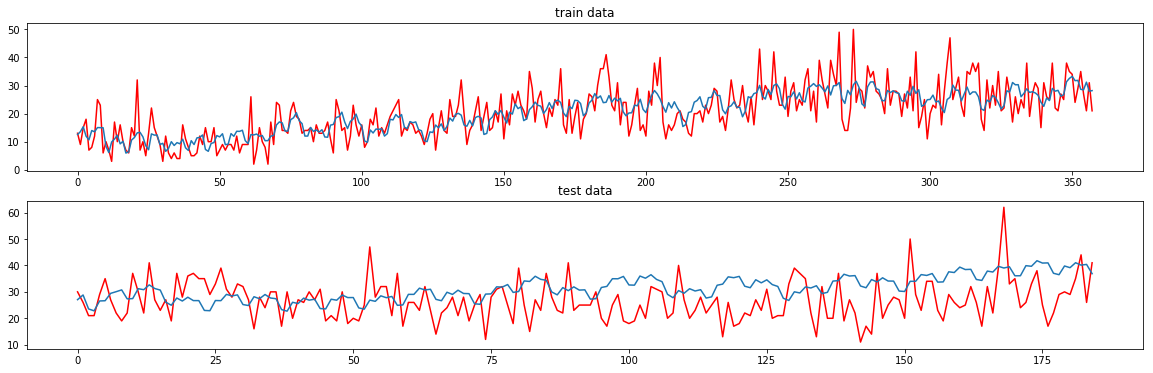

In [125]:
plt.figure(figsize=(20,6))

plt.subplot(2,1,1)
plt.plot(Y_train[7:], color='red')
plt.plot(Y_train_pred)
plt.title('train data')

plt.subplot(2,1,2)
plt.plot(Y_test, color='red')
plt.plot(Y_test_pred)
plt.title('test data')

plt.show()

In [122]:
df_coef = pd.DataFrame( data = {'coef_names': pipe_LR_Seq.named_steps['my_GetFeatureNames'].cols,\
                                'values': pipe_LR_Seq.named_steps['my_LR'].coef_} )

df_coef['abs_values'] = df_coef['values'].apply(lambda x: np.abs(x))

df_coef = df_coef.sort_values('abs_values', ascending=False, na_position='last')

df_coef[ df_coef['coef_names'].apply(lambda x: True if 'Day' not in x else False ) ].head(5)

,coef_names,values,abs_values
24,ew_mean,-13.070510,13.070510
16,prev_1,6.161478,6.161478
17,prev_2,2.851876,2.851876
23,roll_mean,2.121283,2.121283
0,sin_1/365d,-2.060470,2.060470


# Construct an online learning algorithm  
We train a model by using features that depend on the values of Y.  
We want to predict Y for a finite time interval where after calculating every prediction Y_pred we obtain immediately the thrue value of Y_corr and use it  to update the parameters in the final predictor.

In order to be able to construt the desired features that are needed in the prediction step, we construct the methods **seq_update** and **seq_transform**, **seq_predict_and_online_corr**.

In [120]:
pipe_SGD_Seq.set_params( 
    my_SGD__max_iter = 1e6, 
    my_SGD__learning_rate='invscaling',
    my_SGD__eta0=0.00001)


pipe_SGD_Seq.fit(X_train, Y_train[7:])
Y_train_pred = pipe_SGD_Seq.predict(X_train)

Y_test_ONL_pred = pipe_SGD_Seq.seq_predict_and_online_corr(X_test, Y_test)

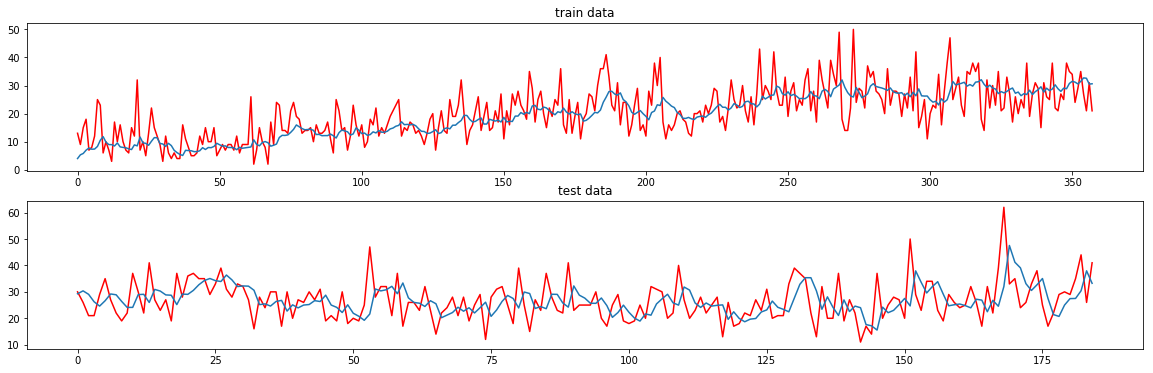

In [121]:
plt.figure(figsize=(20,6))

plt.subplot(2,1,1)
plt.plot(Y_train[7:], color='red')
plt.plot(Y_train_pred)
plt.title('train data')

plt.subplot(2,1,2)
plt.plot(Y_test, color='red')
plt.plot(Y_test_ONL_pred)
plt.title('test data')

plt.show()

In [123]:
df_coef = pd.DataFrame( data = {'coef_names': pipe_SGD_Seq.named_steps['my_GetFeatureNames'].cols,\
                                'values': pipe_SGD_Seq.named_steps['my_SGD'].coef_} )

df_coef['abs_values'] = df_coef['values'].apply(lambda x: np.abs(x))

df_coef = df_coef.sort_values('abs_values', ascending=False, na_position='last')

df_coef[ df_coef['coef_names'].apply(lambda x: True if 'Day' not in x else False ) ].head(5)

,coef_names,values,abs_values
16,prev_1,0.090919,0.090919
21,prev_6,0.086218,0.086218
22,prev_7,0.080379,0.080379
24,ew_mean,0.078197,0.078197
20,prev_5,0.074007,0.074007
